<a href="https://colab.research.google.com/github/Chris-Congleton/Chris-Congleton/blob/main/ReverbChannelTestData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import json, os
import pandas as pd
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')
import seaborn as sns

# regular expression library
import re
# wordcloud library
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

import gensim.corpora as corpora
from pprint import pprint

!pip install pyLDAvis

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
path_ftm = 'gdrive/MyDrive/CS/Thesis/rc_testdata/ftm-nl.article-cleansed-1000-articles.json'
path_joop = 'gdrive/MyDrive/CS/Thesis/rc_testdata/joop-bnnvara-nl.article-cleansed-1000-articles.json'
path_nos = 'gdrive/MyDrive/CS/Thesis/rc_testdata/nos-nl.article-cleansed-1000-articles.json'
path_nu = 'gdrive/MyDrive/CS/Thesis/rc_testdata/nu-nl.article-cleansed-1000-articles.json'
path_volkskrant = 'gdrive/MyDrive/CS/Thesis/rc_testdata/volkskrant-nl.article-cleansed-1000-articles.json'

In [4]:
df_ftm = pd.read_json(path_ftm)
df_joop = pd.read_json(path_joop)
df_nos = pd.read_json(path_nos)
df_nu = pd.read_json(path_nu)
df_volkskrant = pd.read_json(path_volkskrant)

In [5]:
df_ftm["Bron"] = "Follow The Money"
df_joop["Bron"] = "Joop"
df_nos["Bron"] = "NOS"
df_nu["Bron"] = "Nu"
df_volkskrant["Bron"] = "Volkskrant"

dfs = [df_joop, df_ftm, df_nos, df_nu, df_volkskrant]
df_all = pd.concat(dfs, ignore_index=True)

df_all.head()

,categories,cleaned,cleantext,id,keywords,leading-image,leading-image-caption-content,leading-image-caption-source,leading-image-copyright,og-description,og-image,og-title,structure,timestamp,title,url,Bron,html_raw,page_json
0,Video,2019-04-21T11:10:19.878000,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,159241,"[Brexit, Buitenhof, Europa, Europese Unie, Fra...",NaN,,,,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,https://joop.bnnvara.nl/content/uploads/2019/0...,Frans Timmermans: de staat van Europa na weer ...,"\n\t\t<p>Hoe staat Europa ervoor na <a href=""h...",2019-04-14 13:51:58,Frans Timmermans: de staat van Europa na weer ...,https://joop.bnnvara.nl/videos/frans-timmerman...,Joop,NaN,NaN
1,Opinie,2019-04-21T11:10:19.381000,In Frankrijk is ophef ontstaan rond kritiek op...,159237,"[Frankrijk, Hervé di Rosa, Kunst, Racisme, Ste...",NaN,,,,Niemand mag in een vrije maatschappij de macht...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Han van der Horst: Zijn die werken van ...,\n \n\t\t<p>In Frankrijk is ophef ontst...,2019-04-14 12:41:28,Zijn die werken van Hervé di Rosa wel zo racis...,https://joop.bnnvara.nl/opinies/zijn-die-werke...,Joop,NaN,NaN
2,Nieuws,2019-04-21T11:10:18.678000,Twee Franse academici zijn een petitie begonne...,159213,"[Afrika, Frankrijk, Kolonialisme, Racisme]",NaN,,,,Twee Franse academici zijn een petitie begonne...,https://joop.bnnvara.nl/content/uploads/2019/0...,Academici willen racistische muurschildering u...,\n ...,2019-04-14 09:56:04,Academici willen racistische muurschildering u...,https://joop.bnnvara.nl/nieuws/academici-wille...,Joop,NaN,NaN
3,Opinie,2019-04-21T11:10:17.576000,Foto: ANP | Sander Koning Het was afgelopen ma...,159230,"[Forum voor Democratie, GroenLinks, Jesse Klav...",NaN,,,,GroenLinks moet oppassen dat ze niet voor lang...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Joost van Spanje: Weglopen van de wegloper,"\n \n\t\t<figure id=""attachment_159231""...",2019-04-14 09:12:48,Weglopen van de wegloper,https://joop.bnnvara.nl/opinies/weglopen-van-d...,Joop,NaN,NaN
4,Nieuws,2019-04-21T11:10:16.926000,Op 2 april 2019 was de opening van de Vrijheid...,159226,"[Jonathan Holslag, Vrijheid, Vrijheidscolleges]",NaN,,,,Op 2 april 2019 was de opening van de Vrijheid...,https://joop.bnnvara.nl/content/uploads/2019/0...,Vrijheidscollege Jonathan Holslag: &#039;Strij...,\n ...,2019-04-14 09:01:51,Vrijheidscollege Jonathan Holslag: &#8216;Stri...,https://joop.bnnvara.nl/nieuws/vrijheidscolleg...,Joop,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,Sport,2019-10-16T20:19:43.138000,Liverpool-verdediger Virgil van Dijk Beeld Get...,b8167b8c,"[Virgil van Dijk, sport, sportdiscipline, voet...",https://images1.persgroep.net/rcs/kdKvpwPj2ch-...,Liverpool-verdediger Virgil van Dijk,Beeld Getty Images,Beeld Getty Images,Virgil van Dijk (28) kan maandagavond tijdens ...,https://images1.persgroep.net/rcs/kdKvpwPj2ch-...,‘Ik weet bijna zeker dat Virgil van Dijk vanav...,get it from url index blin,2019-09-23 12:44:12,‘Ik weet bijna zeker dat Virgil van Dijk vanav...,https://www.volkskrant.nl/sport/ik-weet-bijna-...,Volkskrant,NaN,"{""@context"":""http://schema.org/"",""@type"":""News..."
4991,Sport,2019-10-16T20:19:43.489000,Is Virgil van Dijk behalve de beste voetballer...,ba54df3e,"[Virgil van Dijk, sportdiscipline, voetbal, sp...",https://images3.persgroep.net/rcs/gY0MSYoxTabm...,None,None,None,Is Virgil van Dijk behalve de beste voetballer...,https://images3.persgroep.net/rcs/jeYy6fxY4W2S...,"Superverdediger, doelpuntenmaker, uitmuntende ...",get it from url index blin,2019-09-23 13:00:00,"Superverdediger, doelpuntenmaker, uitmuntende ...",https://www.volkskrant.nl/sport/superverdedige...,Volkskrant,NaN,"{""@context"":""http://schema.org/"",""@type"":""News..."
4992,Cultuur &amp; Media,2019-10-16T20:19:43.842000,Stef Aerts (l.) als Sigmund Freud en Matteo Si...,b4ffaaf3,"[Jean-Paul Sartre, kunst en entertainment, kun...",

In [6]:
df_all.head()

,categories,cleaned,cleantext,id,keywords,leading-image,leading-image-caption-content,leading-image-caption-source,leading-image-copyright,og-description,og-image,og-title,structure,timestamp,title,url,Bron,html_raw,page_json
0,Video,2019-04-21T11:10:19.878000,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,159241,"[Brexit, Buitenhof, Europa, Europese Unie, Fra...",NaN,,,,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,https://joop.bnnvara.nl/content/uploads/2019/0...,Frans Timmermans: de staat van Europa na weer ...,"\n\t\t<p>Hoe staat Europa ervoor na <a href=""h...",2019-04-14 13:51:58,Frans Timmermans: de staat van Europa na weer ...,https://joop.bnnvara.nl/videos/frans-timmerman...,Joop,NaN,NaN
1,Opinie,2019-04-21T11:10:19.381000,In Frankrijk is ophef ontstaan rond kritiek op...,159237,"[Frankrijk, Hervé di Rosa, Kunst, Racisme, Ste...",NaN,,,,Niemand mag in een vrije maatschappij de macht...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Han van der Horst: Zijn die werken van ...,\n \n\t\t<p>In Frankrijk is ophef ontst...,2019-04-14 12:41:28,Zijn die werken van Hervé di Rosa wel zo racis...,https://joop.bnnvara.nl/opinies/zijn-die-werke...,Joop,NaN,NaN
2,Nieuws,2019-04-21T11:10:18.678000,Twee Franse academici zijn een petitie begonne...,159213,"[Afrika, Frankrijk, Kolonialisme, Racisme]",NaN,,,,Twee Franse academici zijn een petitie begonne...,https://joop.bnnvara.nl/content/uploads/2019/0...,Academici willen racistische muurschildering u...,\n ...,2019-04-14 09:56:04,Academici willen racistische muurschildering u...,https://joop.bnnvara.nl/nieuws/academici-wille...,Joop,NaN,NaN
3,Opinie,2019-04-21T11:10:17.576000,Foto: ANP | Sander Koning Het was afgelopen ma...,159230,"[Forum voor Democratie, GroenLinks, Jesse Klav...",NaN,,,,GroenLinks moet oppassen dat ze niet voor lang...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Joost van Spanje: Weglopen van de wegloper,"\n \n\t\t<figure id=""attachment_159231""...",2019-04-14 09:12:48,Weglopen van de wegloper,https://joop.bnnvara.nl/opinies/weglopen-van-d...,Joop,NaN,NaN
4,Nieuws,2019-04-21T11:10:16.926000,Op 2 april 2019 was de opening van de Vrijheid...,159226,"[Jonathan Holslag, Vrijheid, Vrijheidscolleges]",NaN,,,,Op 2 april 2019 was de opening van de Vrijheid...,https://joop.bnnvara.nl/content/uploads/2019/0...,Vrijheidscollege Jonathan Holslag: &#039;Strij...,\n ...,2019-04-14 09:01:51,Vrijheidscollege Jonathan Holslag: &#8216;Stri...,https://joop.bnnvara.nl/nieuws/vrijheidscolleg...,Joop,NaN,NaN


In [37]:
# Remove the columns
articles = df_all.drop(columns=['id', 'keywords',
                                'leading-image', 'leading-image-caption-content',
                                'leading-image-caption-source', 'leading-image-copyright',
                                'og-description', 'og-image', 'og-title',
                                'structure', 'url', 'html_raw', 'page_json',
                                'categories', 'cleaned'], axis=1).sample(1000)# Print out the first rows of papers
articles.head()

,cleantext,timestamp,title,Bron
954,"Wederom laten de beelden van Animal Rights, ge...",2019-01-11 21:17:16,Undercoverbeelden dierenleed veehouderij: exce...,Joop
2965,De belangrijkste verdachte in het proces tege...,2019-02-14 12:27:46,Catalaanse leider antwoordt niet: ik ben een p...,NOS
3406,Het Openbaar Ministerie (OM) heeft aan drie (...,2019-03-28 16:20:38,"Boetes voor beledigen Leen Schaap, geen bewijs...",Nu
3951,Het cultuurcluster Oudenbosch gaat de gemeent...,2019-03-25 15:13:48,Cultuurcluster Oudenbosch kost bijna miljoen e...,Nu
1854,Redactie De FNV wil zich opheffen en opgaan in...,2011-12-12 09:15:00,Talent levert 100 miljard op,Follow The Money


In [38]:
# Remove punctuation
articles['cleantext_processed'] = \
articles['cleantext'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
articles['cleantext_processed'] = \
articles['cleantext_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
articles['cleantext_processed'].head()

<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<ipython-input-38-341723ed8bf8>:2: DeprecationWarning: invalid escape sequence \.
  articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\.!?]', '', x))


954     wederom laten de beelden van animal rights gem...
2965     de belangrijkste verdachte in het proces tege...
3406     het openbaar ministerie (om) heeft aan drie (...
3951     het cultuurcluster oudenbosch gaat de gemeent...
1854    redactie de fnv wil zich opheffen en opgaan in...
Name: cleantext_processed, dtype: object

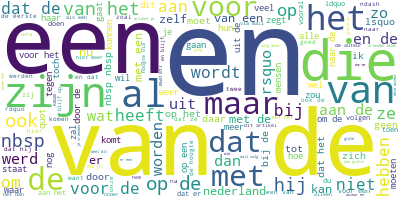

In [39]:
# Join the different processed titles together.
long_string = ','.join(list(articles['cleantext_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [45]:
stop_words.extend(['nbsp',])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = articles.cleantext_processed.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['wederom', 'laten', 'beelden', 'animal', 'rights', 'gemaakt', 'verschillende', 'stallen', 'heel', 'nederland', 'helaas', 'vooral', 'normale', 'gang', 'zaken', 'intensieve', 'veehouderij', 'zien', 'propvolle', 'stallen', 'meerdere', 'etages', 'kale', 'zieke', 'stervende', 'dieren', 'meeste', 'eieren', 'koop', 'nederland']


In [46]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 5), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 4), (27, 1), (28, 1), (29, 1)]


In [47]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0,
  '0.005*"jaar" + 0.005*"we" + 0.004*"wel" + 0.003*"twee" + 0.003*"nederland" '
  '+ 0.003*"volgens" + 0.003*"mensen" + 0.002*"rsquo" + 0.002*"gaat" + '
  '0.002*"tijd"'),
 (1,
  '0.003*"rsquo" + 0.003*"jaar" + 0.003*"mensen" + 0.003*"wel" + 0.003*"twee" '
  '+ 0.003*"we" + 0.002*"gaat" + 0.002*"gaan" + 0.002*"goed" + 0.002*"alleen"'),
 (2,
  '0.004*"we" + 0.003*"jaar" + 0.003*"wel" + 0.003*"the" + 0.003*"rsquo" + '
  '0.003*"gaat" + 0.002*"waar" + 0.002*"nederland" + 0.002*"volgens" + '
  '0.002*"weer"'),
 (3,
  '0.004*"rsquo" + 0.004*"we" + 0.003*"jaar" + 0.003*"wel" + 0.003*"euml" + '
  '0.003*"gaat" + 0.003*"lsquo" + 0.003*"auteur" + 0.003*"waar" + '
  '0.003*"volg"'),
 (4,
  '0.004*"we" + 0.004*"rsquo" + 0.004*"wel" + 0.003*"waar" + 0.003*"lsquo" + '
  '0.002*"nederland" + 0.002*"jaar" + 0.002*"gaan" + 0.002*"beeld" + '
  '0.002*"zegt"'),
 (5,
  '0.004*"we" + 0.004*"wel" + 0.004*"rsquo" + 0.003*"jaar" + 0.003*"waar" + '
  '0.003*"staat" + 0.002*"euro" + 0.002*"lsquo" + 0.002*

In [48]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis = gensimvis.prepare(lda_model, corpus, id2word)

LDAvis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.001946  0.006221       1        1  23.104969
0     -0.010067 -0.010289       2        1  13.116329
3      0.017738  0.008751       3        1  13.029698
1     -0.011127 -0.009709       4        1  10.133912
4     -0.001419  0.000561       5        1   8.408059
2      0.001180  0.011259       6        1   8.108669
5      0.006054  0.001042       7        1   7.809079
7      0.007030 -0.002301       8        1   6.884670
9      0.007721 -0.018187       9        1   5.616871
6     -0.019057  0.012653      10        1   3.787745, topic_info=       Term         Freq        Total Category  logprob  loglift
326    jaar   973.000000   973.000000  Default  30.0000  30.0000
182      we  1143.000000  1143.000000  Default  29.0000  29.0000
1281  video   295.000000   295.000000  Default  28.0000  28.0000
346     wel   827.000000   827.000000  Default  27.0000  27.0000
642   rsquo   800.000000   800.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
491    deel    14.206186   359.901342  Topic10  -6.5147   0.0412
179    waar    16.764189   616.015091  Topic10  -6.3491  -0.3306
318    euro    14.214087   458.223481  Topic10  -6.5141  -0.1997
1558    the    13.641660   431.995184  Topic10  -6.5552  -0.1819
568   lsquo    13.742319   512.687158  Topic10  -6.5479  -0.3458

[851 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
2177       1  0.093132  aangehouden
2177       2  0.069849  aangehouden
2177       3  0.116415  aangehouden
2177       4  0.349245  aangehouden
2177       5  0.093132  aangehouden
...      ...       ...          ...
15041      4  0.586707      zusters
20051      2  0.535396    zuydewijn
16630      1  0.181396       zwager
16630      5  0.181396       zwager
16630     10  0.362791       zwager

[2376 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 4, 2, 5, 3, 6, 8, 10, 7])